# EDA of parents in anatomy dataset

In [1]:
# ruff: noqa: T201, T203
from __future__ import annotations

import os
from pathlib import Path

if Path.cwd().name == "notebooks":
    os.chdir("..")

import logging

import pandas as pd
from dotenv import load_dotenv

from config.config import DATA_DIR
from src.evaluate import analyze_results, get_predictions_with_gt, plot_usage_histograms
from src.formatting import (
    format_oracle_pairs_filepath,
    format_run_path,
    format_storing_pathes_from_run_path,
)
from src.LLM_servers.openai import OpenAIServer
from src.onto_access import OntologyAccess
from src.onto_object import OntologyEntryAttr
from src.processing import parallel_samples_process
from src.prompts.system import BASELINE_INITIALIZATION_MESSAGE
from src.utils import read_oracle_pairs, save_run_results

logging.getLogger().setLevel(logging.WARNING)
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
llm_oracle = OpenAIServer()
llm_oracle.add_system_context(BASELINE_INITIALIZATION_MESSAGE)

In [18]:
DATASET_NAME = "anatomy"
SET_NAME = "human-mouse"
SOURCE_ONTOLOGY, TARGET_ONTOLOGY = "mouse", "human"

DATASET_NAME = "bioml-2024"
SET_NAME = "omim-ordo" #"ncit-doid"
SOURCE_ONTOLOGY, TARGET_ONTOLOGY = "omim", "ordo" #"ncit", "doid"

src_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{SOURCE_ONTOLOGY}.owl"
tgt_onto_path = DATA_DIR / DATASET_NAME / SET_NAME / f"{TARGET_ONTOLOGY}.owl"

onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology omim <data/bioml-2024/omim-ordo/omim.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/omim-ordo/omim.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology omim from data/bioml-2024/omim-ordo/omim.owl...


* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasExactSynonym: new triples are now available.
* Owlready2 * Reseting property obo.IAO_0100001: new triples are now available.


* Owlready2 *     ...12 properties found: label, hasExactSynonym, use_in_alignment, IAO_0100001, IAO_0000142, RO_0002200, RO_0002525, RO_0003303, consider, hasSynonymType, exactMatch, category
* Owlready2 * Creating new ontology ordo <data/bioml-2024/omim-ordo/ordo.owl#>.
* Owlready2 * ADD TRIPLE data/bioml-2024/omim-ordo/ordo.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology ordo from data/bioml-2024/omim-ordo/ordo.owl...


* Owlready2 * Reseting property ann.use_in_alignment: new triples are now available.


* Owlready2 *     ...41 properties found: BFO_0000050, Orphanet_317343, Orphanet_317344, Orphanet_317345, Orphanet_317346, Orphanet_317348, Orphanet_317349, Orphanet_327767, Orphanet_410295, Orphanet_410296, Orphanet_465410, Orphanet_C016, Orphanet_C017, Orphanet_C020, Orphanet_C022, Orphanet_C025, Orphanet_C026, Orphanet_C027, Orphanet_C024, Orphanet_C028, Orphanet_C029, Orphanet_C030, Orphanet_C032, Orphanet_C040, label, versionInfo, alternative_term, use_in_alignment, ECO_0000205, ECO_0000218, creator, created, license, modified, definition, definition_citation, reason_for_obsolescence, symbol, notation, permits, requires


### Utils Functions

In [19]:
def select_best_direct_entity_names(
    src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr
) -> list[OntologyEntryAttr, OntologyEntryAttr]:
    """If there are multiple direct parents, select one and find child element for it."""
    src_parents = next(iter(src_entity.get_direct_parents()))
    tgt_parents = next(iter(tgt_entity.get_direct_parents()))
    return [x.get_preffered_names() if x else None for x in [src_parents, tgt_parents, src_entity, tgt_entity]]


def format_hierarchy(hierarchy_dict: dict[int, set[OntologyEntryAttr]], no_level: bool = False) -> str:
    formatted = []
    for level, parents in sorted(hierarchy_dict.items()):
        parent_name = next(iter(next(iter(parents)).get_all_entity_names()))
        if no_level:
            formatted.append(parent_name)
        else:
            formatted.append(f"\tLevel {level}: {parent_name}")

    if no_level:
        return formatted
    return "\n".join(formatted)

### Prompt templates

In [20]:
def prompt_direct_entity(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Regular prompt that uses natural language and is more intuitive."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names = select_best_direct_entity_names(src_entity, tgt_entity)
    return f"""We have two entities from different biomedical ontologies.
The first one is "{src_entity_names}", which falls under the category "{src_parent}".
The second one is "{tgt_entity_names}", which falls under the category "{tgt_parent}".

Do they mean the same thing? Respond with "True" or "False".
"""


def prompt_direct_entity_ontological(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Ontological prompt that uses ontology-focused language."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names = select_best_direct_entity_names(src_entity, tgt_entity)
    return f"""Analyze the following entities, each originating from a distinct biomedical ontology.
Your task is to assess whether they represent the **same ontological concept**, considering both their semantic meaning and hierarchical position.

1. Source entity: "{src_entity_names}"
\t- Direct ontological parent: "{src_parent}"

2. Target entity: "{tgt_entity_names}"
\t- Direct ontological parent: "{tgt_parent}"

Are these entities **ontologically equivalent** within their respective ontologies? Respond with "True" or "False".
"""  # noqa: E501


def prompt_sequential_hierarchy(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Regular prompt that uses natural language and is more intuitive."""
    src_hierarchy = format_hierarchy(src_entity.get_parents_by_levels(max_level=3), True)
    tgt_hierarchy = format_hierarchy(tgt_entity.get_parents_by_levels(max_level=3), True)

    return "\n".join(
        [
            "We have two entities from different biomedical ontologies.",
            (
                f'The first one is "{src_entity.get_preffered_names()}"'
                + (f', which belongs to the broader category "{src_hierarchy[0]}"' if len(src_hierarchy) >= 1 else "")
                + (f', under the even broader category "{src_hierarchy[1]}"' if len(src_hierarchy) >= 2 else "")
            ),
            (
                f'The second one is "{tgt_entity.get_preffered_names()}"'
                + (f', which belongs to the broader category "{tgt_hierarchy[0]}"' if len(tgt_hierarchy) >= 1 else "")
                + (f', under the even broader category "{tgt_hierarchy[1]}"' if len(tgt_hierarchy) >= 2 else "")
            ),
            'Do they mean the same thing? Respond with "True" or "False".',
        ]
    )


def prompt_sequential_hierarchy_ontological(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Ontological prompt that uses ontology-focused language, and takes hierarchical relationships into account."""
    src_hierarchy = format_hierarchy(src_entity.get_parents_by_levels(max_level=3))
    tgt_hierarchy = format_hierarchy(tgt_entity.get_parents_by_levels(max_level=3))

    return f"""The following entities come from distinct biomedical ontologies.
Each is represented by its **ontological lineage**, capturing its hierarchical placement from the most general to the most specific level.

1. Source entity ontological lineage:
{src_hierarchy}

2. Target entity ontological lineage:
{tgt_hierarchy}

Based on their **ontological positioning, hierarchical relationships, and semantic alignment**, do these entities represent the **same ontological concept**? Respond with "True" or "False".
"""  # noqa: E501


### Test synonyms prompting

In [21]:
TGT_DELIMITER = (
    "/" if DATASET_NAME == "bioml-2024" else "#"
)  # for bioml only because src we need to split by # and tgt by /


def select_best_direct_entity_names_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> list:
    """Selects the best direct entity names and retrieves synonyms for entities and their parents."""

    src_parents = next(iter(src_entity.get_direct_parents()), None)
    tgt_parents = next(iter(tgt_entity.get_direct_parents()), None)

    src_parent_name = src_parents.get_preffered_names() if src_parents else None
    tgt_parent_name = tgt_parents.get_preffered_names() if tgt_parents else None

    src_entity_name = src_entity.get_preffered_names()
    tgt_entity_name = tgt_entity.get_preffered_names()

    src_synonyms = list(src_entity.get_synonyms()) or []
    tgt_synonyms = list(tgt_entity.get_synonyms()) or []

    src_entity_class = src_entity.annotation["uri"].rsplit("#", 1)[-1]
    tgt_entity_class = tgt_entity.annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]

    # Remove synonyms that are just the entity class name
    if len(src_synonyms) == 1 and src_synonyms[0] == src_entity_class:
        src_synonyms = []
    if len(tgt_synonyms) == 1 and tgt_synonyms[0] == tgt_entity_class:
        tgt_synonyms = []

    return [src_parent_name, tgt_parent_name, src_entity_name, tgt_entity_name, src_synonyms, tgt_synonyms]


def select_best_sequential_hierarchy_with_synonyms(src_parents_by_levels, tgt_parents_by_levels):
    """Selects the best synonyms for an entity and its hierarchical parents."""

    def get_first_synonyms(parent_set):
        """Safely retrieves synonyms from the first available parent entity in the set."""
        if parent_set:
            parent = next(iter(parent_set))
            return parent.get_synonyms() if hasattr(parent, "get_synonyms") else []
        return []

    src_synonyms = get_first_synonyms(src_parents_by_levels[0])
    src_entity_class = next(iter(src_parents_by_levels[0])).annotation["uri"].rsplit("#", 1)[-1]

    src_parent1_synonyms = get_first_synonyms(src_parents_by_levels[1]) if len(src_parents_by_levels) > 1 else []
    src_parent1_class = (
        next(iter(src_parents_by_levels[1])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 1
        else []
    )

    src_parent2_synonyms = get_first_synonyms(src_parents_by_levels[2]) if len(src_parents_by_levels) > 2 else []
    src_parent2_class = (
        next(iter(src_parents_by_levels[2])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 2
        else []
    )

    src_parent3_synonyms = get_first_synonyms(src_parents_by_levels[3]) if len(src_parents_by_levels) > 3 else []
    src_parent3_class = (
        next(iter(src_parents_by_levels[3])).annotation["uri"].rsplit("#", 1)[-1]
        if len(src_parents_by_levels) > 3
        else []
    )

    tgt_synonyms = get_first_synonyms(tgt_parents_by_levels[0])
    tgt_entity_class = next(iter(tgt_parents_by_levels[0])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]

    tgt_parent1_synonyms = get_first_synonyms(tgt_parents_by_levels[1]) if len(tgt_parents_by_levels) > 1 else []
    tgt_parent1_class = (
        next(iter(tgt_parents_by_levels[1])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 1
        else []
    )

    tgt_parent2_synonyms = get_first_synonyms(tgt_parents_by_levels[2]) if len(tgt_parents_by_levels) > 2 else []
    tgt_parent2_class = (
        next(iter(tgt_parents_by_levels[2])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 2
        else []
    )

    tgt_parent3_synonyms = get_first_synonyms(tgt_parents_by_levels[3]) if len(tgt_parents_by_levels) > 3 else []
    tgt_parent3_class = (
        next(iter(tgt_parents_by_levels[3])).annotation["uri"].rsplit(TGT_DELIMITER, 1)[-1]
        if len(tgt_parents_by_levels) > 3
        else []
    )

    def clean_synonyms(synonyms, synonym_class):
        return [] if len(synonyms) == 1 and next(iter(synonyms)) == synonym_class else synonyms

    src_synonyms = clean_synonyms(src_synonyms, src_entity_class)
    src_parent1_synonyms = clean_synonyms(src_parent1_synonyms, src_parent1_class)
    src_parent2_synonyms = clean_synonyms(src_parent2_synonyms, src_parent2_class)
    src_parent3_synonyms = clean_synonyms(src_parent3_synonyms, src_parent3_class)

    tgt_synonyms = clean_synonyms(tgt_synonyms, tgt_entity_class)
    tgt_parent1_synonyms = clean_synonyms(tgt_parent1_synonyms, tgt_parent1_class)
    tgt_parent2_synonyms = clean_synonyms(tgt_parent2_synonyms, tgt_parent2_class)
    tgt_parent3_synonyms = clean_synonyms(tgt_parent3_synonyms, tgt_parent3_class)

    return [
        src_synonyms,
        src_parent1_synonyms,
        src_parent2_synonyms,
        src_parent3_synonyms,
        tgt_synonyms,
        tgt_parent1_synonyms,
        tgt_parent2_synonyms,
        tgt_parent3_synonyms,
    ]

In [7]:
def prompt_direct_entity_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Natural language prompt that includes synonyms for a more intuitive comparison."""
    src_parent, tgt_parent, src_entity_names, tgt_entity_names, src_synonyms, tgt_synonyms = (
        select_best_direct_entity_names_with_synonyms(src_entity, tgt_entity)
    )

    src_synonyms_text = f", also known as {', '.join(src_synonyms)}" if src_synonyms else ""
    tgt_synonyms_text = f", also known as {', '.join(tgt_synonyms)}" if tgt_synonyms else ""

    return f"""We have two entities from different biomedical ontologies.
The first one is "{src_entity_names}"{src_synonyms_text}, which falls under the category "{src_parent}".
The second one is "{tgt_entity_names}"{tgt_synonyms_text}, which falls under the category "{tgt_parent}".

Do they refer to the same concept? Respond with "True" or "False".
"""


def prompt_sequential_hierarchy_with_synonyms(src_entity: OntologyEntryAttr, tgt_entity: OntologyEntryAttr) -> str:
    """Generates a natural language prompt including synonyms and hierarchical relationships."""

    src_parents_by_levels = src_entity.get_parents_by_levels(max_level=3)
    tgt_parents_by_levels = tgt_entity.get_parents_by_levels(max_level=3)

    (
        src_synonyms,
        src_parent1_synonyms,
        src_parent2_synonyms,
        src_parent3_synonyms,
        tgt_synonyms,
        tgt_parent1_synonyms,
        tgt_parent2_synonyms,
        tgt_parent3_synonyms,
    ) = select_best_sequential_hierarchy_with_synonyms(src_parents_by_levels, tgt_parents_by_levels)

    src_hierarchy = format_hierarchy(src_parents_by_levels, True)
    tgt_hierarchy = format_hierarchy(tgt_parents_by_levels, True)

    src_entity_name = f'"{src_hierarchy[0]}"'
    if src_synonyms:
        src_entity_name += f""", also known as {", ".join(f'"{syn}"' for syn in src_synonyms)}"""

    tgt_entity_name = f'"{tgt_hierarchy[0]}"'
    if tgt_synonyms:
        tgt_entity_name += f""", also known as {", ".join(f'"{syn}"' for syn in tgt_synonyms)}"""

    src_hierarchy_text = ""
    if len(src_hierarchy) >= 2:
        src_hierarchy_text += f', which belongs to the broader category "{src_hierarchy[1]}"'
        if src_parent1_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent1_synonyms)})"""
    if len(src_hierarchy) >= 3:
        src_hierarchy_text += f', under the even broader category "{src_hierarchy[2]}"'
        if src_parent2_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent2_synonyms)})"""
    if len(src_hierarchy) >= 4:
        src_hierarchy_text += f', under the even broader category "{src_hierarchy[3]}"'
        if src_parent3_synonyms:
            src_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in src_parent3_synonyms)})"""

    tgt_hierarchy_text = ""
    if len(tgt_hierarchy) >= 2:
        tgt_hierarchy_text += f', which belongs to the broader category "{tgt_hierarchy[1]}"'
        if tgt_parent1_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent1_synonyms)})"""
    if len(tgt_hierarchy) >= 3:
        tgt_hierarchy_text += f', under the even broader category "{tgt_hierarchy[2]}"'
        if tgt_parent2_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent2_synonyms)})"""
    if len(tgt_hierarchy) >= 4:
        tgt_hierarchy_text += f', under the even broader category "{tgt_hierarchy[3]}"'
        if tgt_parent3_synonyms:
            tgt_hierarchy_text += f""" (also known as {", ".join(f'"{syn}"' for syn in tgt_parent3_synonyms)})"""

    return "\n".join(
        [
            "We have two entities from different biomedical ontologies.",
            f"The first one is {src_entity_name}{src_hierarchy_text}.",
            f"The second one is {tgt_entity_name}{tgt_hierarchy_text}.",
            'Do they mean the same thing? Respond with "True" or "False".',
        ]
    )

In [22]:
src_entity, tgt_entity = read_oracle_pairs(format_oracle_pairs_filepath(DATASET_NAME, SET_NAME))[5]
try:
    src_entity, tgt_entity = OntologyEntryAttr(src_entity, onto_src), OntologyEntryAttr(tgt_entity, onto_tgt)
except AssertionError:
    src_entity, tgt_entity = OntologyEntryAttr(tgt_entity, onto_src), OntologyEntryAttr(src_entity, onto_tgt)

In [23]:
print(prompt_direct_entity_with_synonyms(src_entity, tgt_entity))

We have two entities from different biomedical ontologies.
The first one is "{'aicardi syndrome'}", also known as AIC, which falls under the category "{'Thing'}".
The second one is "{'Aicardi syndrome'}", also known as Agenesis of corpus callosum with chorioretinal abnormality, which falls under the category "{'disease'}".

Do they refer to the same concept? Respond with "True" or "False".



In [24]:
print(prompt_sequential_hierarchy_with_synonyms(src_entity, tgt_entity))

We have two entities from different biomedical ontologies.
The first one is "aicardi syndrome", also known as "AIC", which belongs to the broader category "Thing".
The second one is "Agenesis of corpus callosum with chorioretinal abnormality", also known as "Agenesis of corpus callosum with chorioretinal abnormality", which belongs to the broader category "disease", under the even broader category "clinical entity", under the even broader category "Thing" (also known as "Thing").
Do they mean the same thing? Respond with "True" or "False".


In [25]:
EXP_NAMES_TO_PROMPT_FUNCTIONS = {
    prompt_function.__name__.replace("prompt_", ""): prompt_function
    for prompt_function in [
        prompt_direct_entity_with_synonyms,
        prompt_sequential_hierarchy_with_synonyms
    ]
}

src_entity, tgt_entity = read_oracle_pairs(format_oracle_pairs_filepath(DATASET_NAME, SET_NAME))[0]
try:
    src_entity, tgt_entity = OntologyEntryAttr(src_entity, onto_src), OntologyEntryAttr(tgt_entity, onto_tgt)
except AssertionError:
    src_entity, tgt_entity = OntologyEntryAttr(tgt_entity, onto_src), OntologyEntryAttr(src_entity, onto_tgt)

print(src_entity)
print(tgt_entity)

for name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    print(f"Prompt function: {name}")
    print(prompt_function(src_entity, tgt_entity))
    print("=" * 50)

{'class': phenotypicSeries.PS277400, 'uri': 'http://www.omim.org/phenotypicSeries/PS277400', 'preffered_names': {'Methylmalonic aciduria and homocystinuria'}, 'synonyms': {'PS277400'}, 'all_names': {'Methylmalonic aciduria and homocystinuria'}, 'parents': {owl.Thing}, 'children': {entry.309541, entry.277400, entry.277380, entry.614857, entry.277410}}
{'class': ORDO.Orphanet_293355, 'uri': 'http://www.orpha.net/ORDO/Orphanet_293355', 'preffered_names': {'Methylmalonic acidemia without homocystinuria'}, 'synonyms': {'Methylmalonic aciduria without homocystinuria'}, 'all_names': {'Methylmalonic aciduria without homocystinuria', 'Methylmalonic acidemia without homocystinuria'}, 'parents': {ORDO.Orphanet_79062, ORDO.Orphanet_68367, ORDO.Orphanet_C001, ORDO.Orphanet_98053, ORDO.Orphanet_79163, ORDO.Orphanet_289899, owl.Thing, ORDO.Orphanet_377794}, 'children': set()}
Prompt function: direct_entity_with_synonyms
We have two entities from different biomedical ontologies.
The first one is "{'Me

### Run experiments

Processing Lines prompt_direct_entity_with_synonyms: 100%|██████████| 1464/1464 [14:51<00:00,  1.64it/s]


Mean input tockens: 186.0
Mean output tockens: 6.0
Total input tockens: 272351
Total output tockens: 8784


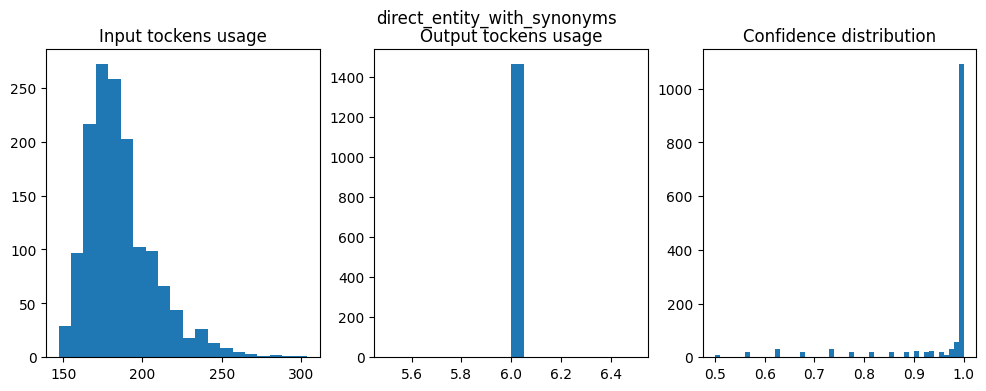

Accuracy: 0.796
Precision: 0.868
Recall: 0.872
F1 Score: 0.870


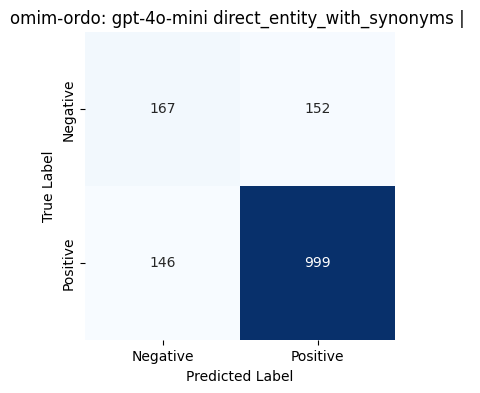

Processing Lines prompt_sequential_hierarchy_with_synonyms: 100%|██████████| 1464/1464 [22:28<00:00,  1.09it/s]


Mean input tockens: 210.4
Mean output tockens: 6.0
Total input tockens: 308086
Total output tockens: 8784


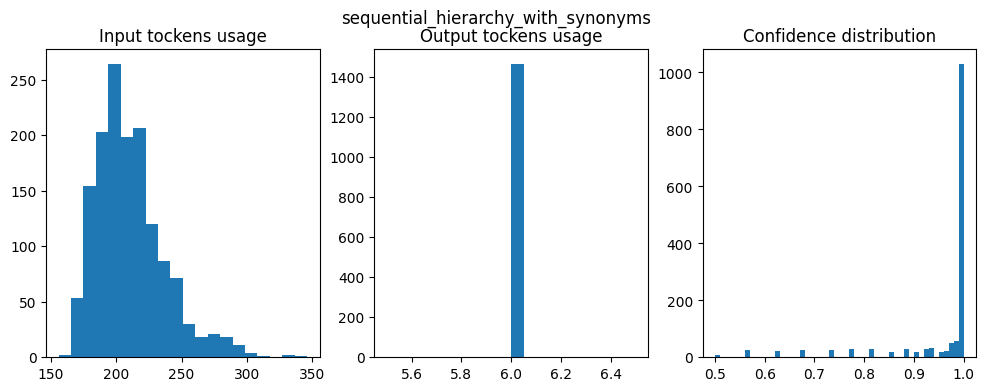

Accuracy: 0.572
Precision: 0.871
Recall: 0.532
F1 Score: 0.661


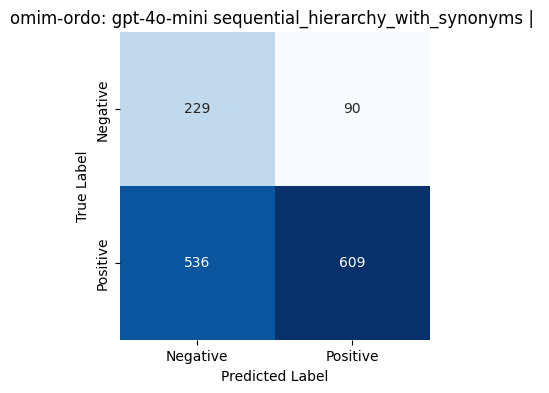

In [26]:
MAX_WORKERS = 25
MODEL = "gpt-4o-mini"

oracle_candidate_pairs_path = format_oracle_pairs_filepath(DATASET_NAME, SET_NAME)

oracle_candidate_pairs = read_oracle_pairs(oracle_candidate_pairs_path)[:]

run_path = format_run_path()

for current_exp_name, prompt_function in EXP_NAMES_TO_PROMPT_FUNCTIONS.items():
    results, tokens_usage, confidences = parallel_samples_process(
        oracle_candidate_pairs, llm_oracle, onto_src, onto_tgt, MODEL, MAX_WORKERS, prompt_function
    )
    prediction_path, stats_path, diagram_path = format_storing_pathes_from_run_path(
        run_path, SET_NAME, MODEL, current_exp_name
    )
    save_run_results(results, prediction_path, columns=["Source", "Target", "Prediction", "Confidence"])

    plot_usage_histograms(tokens_usage, confidences, do_plot=True, do_print=True, suptitle=current_exp_name)

    predictions = get_predictions_with_gt(run_path, DATASET_NAME, SET_NAME, MODEL, current_exp_name)
    analyze_results(
        predictions,
        print_results=True,
        plot_confusion_matrix=True,
        subtitle=f"{SET_NAME}: {MODEL} {current_exp_name} | ",
        cm_save_path=diagram_path,
        stats_path=stats_path,
    )
    print("\n")


## Analysis

In [27]:
results_data = []

# run_path = Path("runs/2025-03-02_10-11-18")

for exp_name in EXP_NAMES_TO_PROMPT_FUNCTIONS:
    _, stats_path, _ = format_storing_pathes_from_run_path(run_path, SET_NAME, MODEL, exp_name)
    stats = pd.read_csv(stats_path, index_col=0).T
    results_data.append(
        {
            "Experiment": exp_name,
            **{key: stats[key].to_numpy()[0] for key in stats.columns},
        }
    )

results_df = pd.DataFrame(results_data).round(4)
results_df.to_csv(run_path / "results.csv", index=False)
results_df

,Experiment,Accuracy,Precision,Recall,F1 Score
0,direct_entity_with_synonyms,0.7964,0.8679,0.8725,0.8702
1,sequential_hierarchy_with_synonyms,0.5724,0.8712,0.5319,0.6605
